In [1]:
%matplotlib inline

from __future__ import print_function
import avltree_eaf3d as bst
import eaf3D
import numpy as np
import pandas as pd
import seaborn
from copy import deepcopy
from distutils.version import LooseVersion
from glob import glob
from matplotlib import patches, pyplot, rc, ticker
from mpl_toolkits.mplot3d import Axes3D
from operator import attrgetter
from stack import Stack

import matplotlib as mpl
from seaborn import utils
from seaborn.palettes import color_palette

In [32]:
folder = 'NSGA-II/'
sets = eaf3D.retrieve_input_sequences(folder + 'Cookies1000/')
eaf_maker = eaf3D.EAF_3D(sets)
eaf_maker.transform()

In [33]:
opcat = ['No. of Bins', 'Avg. Initial Bin Heat (W)', 'Max. Time to Move (s)']
kwargs = {'MethodName': 'NSGA-II',
          'SuperLevels': [0, 4, 9, 14, 19],
              'opcat': opcat,
              'folder': folder,
              'opal': 1}

df_lsa = eaf_maker.make_lsa_dataframe(**kwargs)
df_x = eaf_maker.make_x_dataframe(**kwargs)
print(df_lsa)

    Avg. Initial Bin Heat (W)  Max. Time to Move (s)  No. of Bins  \
0                   24.645707            9391.874230         56.0   
1                   29.584875            9451.519368         49.0   
2                   20.528469            9242.182815         62.0   
3                   31.658586            9526.495086         43.0   
4                   26.703042            9203.423062         53.0   
5                   21.812022            9212.064611         60.0   
6                   18.657658            8936.224842         65.0   
7                   31.251638            9417.830604         45.0   
8                   27.387723            9273.392033         51.0   
9                   24.992392            9097.830291         54.0   
10                  22.182548            8988.310868         59.0   
11                  21.534203            9137.706954         61.0   
12                  20.077065            8833.800688         63.0   
13                  32.739171     

In [34]:
# Set environment for graphs
colors = ['#49ADA2', '#7797F4', '#C973F4', '#EF6E8B', '#FFCCCC', '#FFAA6C']
superlevels = list(range(eaf_maker.n))

# Set boundaries for problem
print(df_lsa.max(axis=0))
print(df_lsa.min(axis=0))
lim0 = (20, 160)      
lim1 = (0.0, 55.0)
lim2 = (8000.0, 10000.0) 
lim = [lim0, lim1, lim2]
limits = [lim0 for _ in range(3)]
limits.extend([lim1 for _ in range(3)])
limits.extend([lim2 for _ in range(3)])

# Set colors for lsa data and for x data
pal = seaborn.dark_palette(colors[kwargs['opal']], reverse=True)
cmap = seaborn.light_palette(colors[kwargs['opal']], as_cmap=True)

Avg. Initial Bin Heat (W)      40.109413
Max. Time to Move (s)        9526.495086
No. of Bins                    65.000000
SuperLevel t/n [%]            100.000000
dtype: float64
Avg. Initial Bin Heat (W)      18.657658
Max. Time to Move (s)        8712.063045
No. of Bins                    42.000000
SuperLevel t/n [%]              5.000000
dtype: float64


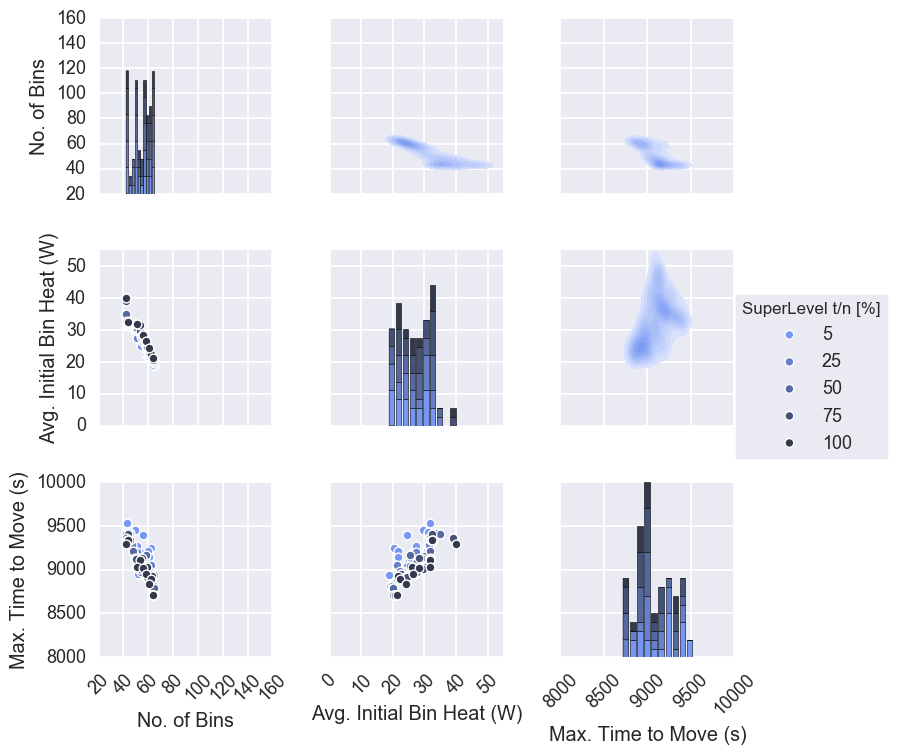

In [35]:
plotname = kwargs['folder'] + '1000eaf_ScatterMatrix_' + kwargs['MethodName']
# Plot PairGrid with diagnol and map_lower
scat = seaborn.PairGrid(df_lsa, vars=opcat, hue='SuperLevel t/n [%]', palette=pal)
scat = scat.map_diag(pyplot.hist)
scat = scat.map_lower(pyplot.scatter, linewidths=1, edgecolor="w", s=40)
# Plot df_x in map_upper manually
subplots_newdf = [(0, 1), (0, 2), (1, 2)]
for (i, j) in subplots_newdf:
    ax = scat.axes[i, j]
    x_var = scat.x_vars[j]
    y_var = scat.y_vars[i]
    seaborn.kdeplot(df_x[x_var], df_x[y_var], shade=True, shade_lowest=False, ax=ax, cmap=cmap)
    ax.set_xlabel("")
    ax.set_ylabel("")
# Set the tick labels to be at a 45 degree angle for better fit
sp = 0
for ax in scat.axes.flat:
    ax.set_xlim(limits[((sp + 3) % 3) * 3])
    ax.set_ylim(limits[sp])
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda xax, p: format(int(xax))))
    pyplot.setp(ax.get_xticklabels(), rotation=45)
    sp += 1
scat.add_legend(frameon=True)
# scat.fig.get_children()[-1].set_bbox_to_anchor((0.995, 0.89, 0, 0))
pyplot.savefig(plotname + '.eps', format='eps', dpi=4000)
pyplot.savefig(plotname + '.pdf', format='pdf', dpi=4000)

In [67]:
class PartialGrid(seaborn.axisgrid.Grid):
    """Subplot grid for plotting pairwise relationships in a dataset."""

    def __init__(self, data, hue=None, hue_order=None, palette=None,
                 hue_kws=None, vars=None, x_vars=None, y_vars=None,
                 diag_sharey=True, size=2.5, aspect=1,
                 despine=True, dropna=True):

        # Sort out the variables that define the grid
        if vars is not None:
            x_vars = list(vars)
            y_vars = list(vars)
        elif (x_vars is not None) or (y_vars is not None):
            if (x_vars is None) or (y_vars is None):
                raise ValueError("Must specify `x_vars` and `y_vars`")
        else:
            numeric_cols = self._find_numeric_cols(data)
            x_vars = numeric_cols
            y_vars = numeric_cols

        if np.isscalar(x_vars):
            x_vars = [x_vars]
        if np.isscalar(y_vars):
            y_vars = [y_vars]

        self.x_vars = list(x_vars)
        self.y_vars = list(y_vars)
        self.square_grid = self.x_vars == self.y_vars

        # Create the partial figure and the array of subplots
        figsize = (len(x_vars) - 1 ) * size * aspect, (len(y_vars) - 1) * size

        fig, axes = pyplot.subplots(len(y_vars) - 1, len(x_vars) - 1, figsize=figsize,
                                    sharex="col", sharey="row", squeeze=False)

        self.fig = fig
        self.axes = axes
        self.data = data

        # Save what we are going to do with the diagonal
        self.diag_sharey = diag_sharey
        self.diag_axes = None

        # Label the axes
        self._add_axis_labels()

        # Sort out the hue variable
        self._hue_var = hue
        if hue is None:
            self.hue_names = ["_nolegend_"]
            self.hue_vals = pd.Series(["_nolegend_"] * len(data),
                                      index=data.index)
        else:
            hue_names = utils.categorical_order(data[hue], hue_order)
            if dropna:
                # Filter NA from the list of unique hue names
                hue_names = list(filter(pd.notnull, hue_names))
            self.hue_names = hue_names
            self.hue_vals = data[hue]

        # Additional dict of kwarg -> list of values for mapping the hue var
        self.hue_kws = hue_kws if hue_kws is not None else {}

        self.palette = self._get_palette(data, hue, hue_order, palette)
        self._legend_data = {}

        # Make the plot look nice
        if despine:
            utils.despine(fig=fig)
        fig.tight_layout()

    def map(self, func, **kwargs):
        """Plot with the same function in every subplot.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """
        kw_color = kwargs.pop("color", None)
        for i, y_var in enumerate(self.y_vars):
            for j, x_var in enumerate(self.x_vars):
                hue_grouped = self.data.groupby(self.hue_vals)
                for k, label_k in enumerate(self.hue_names):

                    # Attempt to get data for this level, allowing for empty
                    try:
                        data_k = hue_grouped.get_group(label_k)
                    except KeyError:
                        data_k = pd.DataFrame(columns=self.data.columns,
                                              dtype=np.float)

                    ax = self.axes[i, j]
                    pyplot.sca(ax)

                    # Insert the other hue aesthetics if appropriate
                    for kw, val_list in self.hue_kws.items():
                        kwargs[kw] = val_list[k]

                    color = self.palette[k] if kw_color is None else kw_color
                    func(data_k[x_var], data_k[y_var],
                         label=label_k, color=color, **kwargs)

                self._clean_axis(ax)
                self._update_legend_data(ax)

        if kw_color is not None:
            kwargs["color"] = kw_color
        self._add_axis_labels()

        return self

    def map_diag(self, func, **kwargs):
        """Plot with a univariate function on each diagonal subplot.
        Parameters
        ----------
        func : callable plotting function
            Must take an x array as a positional arguments and draw onto the
            "currently active" matplotlib Axes. There is a special case when
            using a ``hue`` variable and ``plt.hist``; the histogram will be
            plotted with stacked bars.
        """
        # Add special diagonal axes for the univariate plot
        if self.square_grid and self.diag_axes is None:
            diag_axes = []
            for i, (var, ax) in enumerate(zip(self.x_vars,
                                              np.diag(self.axes))):
                if i and self.diag_sharey:
                    diag_ax = ax._make_twin_axes(sharex=ax,
                                                 sharey=diag_axes[0],
                                                 frameon=False)
                else:
                    diag_ax = ax._make_twin_axes(sharex=ax, frameon=False)
                diag_ax.set_axis_off()
                diag_axes.append(diag_ax)
            self.diag_axes = np.array(diag_axes, np.object)

        # Plot on each of the diagonal axes
        for i, var in enumerate(self.x_vars):
            ax = self.diag_axes[i]
            hue_grouped = self.data[var].groupby(self.hue_vals)

            # Special-case plt.hist with stacked bars
            if func is pyplot.hist:
                pyplot.sca(ax)
                vals = []
                for label in self.hue_names:
                    # Attempt to get data for this level, allowing for empty
                    try:
                        vals.append(np.asarray(hue_grouped.get_group(label)))
                    except KeyError:
                        vals.append(np.array([]))

                # check and see if histtype override was provided in kwargs
                if 'histtype' in kwargs:
                    func(vals, color=self.palette, **kwargs)
                else:
                    func(vals, color=self.palette, histtype="barstacked",
                         **kwargs)
            else:
                for k, label_k in enumerate(self.hue_names):
                    # Attempt to get data for this level, allowing for empty
                    try:
                        data_k = hue_grouped.get_group(label_k)
                    except KeyError:
                        data_k = np.array([])
                    pyplot.sca(ax)
                    func(data_k, label=label_k,
                         color=self.palette[k], **kwargs)

            self._clean_axis(ax)

        self._add_axis_labels()

        return self

    def map_lower(self, func, **kwargs):
        """Plot with a bivariate function on the lower diagonal subplots.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """
        kw_color = kwargs.pop("color", None)
        subplots = [(0, 0), (1, 0), (1, 1)]
        subplots_vars = [(0, 1), (0, 2), (1, 2)]
        for pn in range(len(subplots)):
            i, j = subplots[pn]
            hue_grouped = self.data.groupby(self.hue_vals)
            for k, label_k in enumerate(self.hue_names):

                # Attempt to get data for this level, allowing for empty
                try:
                    data_k = hue_grouped.get_group(label_k)
                except KeyError:
                    data_k = pd.DataFrame(columns=self.data.columns,
                                          dtype=np.float)

                ax = self.axes[i, j]
                pyplot.sca(ax)

                x_var = self.x_vars[subplots_vars[pn][0]]
                y_var = self.y_vars[subplots_vars[pn][1]]

                # Insert the other hue aesthetics if appropriate
                for kw, val_list in self.hue_kws.items():
                    kwargs[kw] = val_list[k]

                color = self.palette[k] if kw_color is None else kw_color
                func(data_k[x_var], data_k[y_var], label=label_k,
                     color=color, **kwargs)

            self._clean_axis(ax)
            self._update_legend_data(ax)

        if kw_color is not None:
            kwargs["color"] = kw_color
        self._add_axis_labels()

        return self

    def map_upper(self, func, **kwargs):
        """Plot with a bivariate function on the upper diagonal subplots.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """
        kw_color = kwargs.pop("color", None)
        for i, j in zip(*np.triu_indices_from(self.axes, 1)):

            hue_grouped = self.data.groupby(self.hue_vals)

            for k, label_k in enumerate(self.hue_names):

                # Attempt to get data for this level, allowing for empty
                try:
                    data_k = hue_grouped.get_group(label_k)
                except KeyError:
                    data_k = pd.DataFrame(columns=self.data.columns,
                                          dtype=np.float)

                ax = self.axes[i, j]
                pyplot.sca(ax)

                x_var = self.x_vars[j]
                y_var = self.y_vars[i]

                # Insert the other hue aesthetics if appropriate
                for kw, val_list in self.hue_kws.items():
                    kwargs[kw] = val_list[k]

                color = self.palette[k] if kw_color is None else kw_color
                func(data_k[x_var], data_k[y_var], label=label_k,
                     color=color, **kwargs)

            self._clean_axis(ax)
            self._update_legend_data(ax)

        if kw_color is not None:
            kwargs["color"] = kw_color

        return self

    def map_offdiag(self, func, **kwargs):
        """Plot with a bivariate function on the off-diagonal subplots.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """

        self.map_lower(func, **kwargs)
        self.map_upper(func, **kwargs)
        return self
    
    def map_corner(self,):
        seaborn.set_style('whitegrid')
        ax = self.axes[0, 1]
        ax.scatter(df_lsa[opcat[0]], df_lsa[opcat[1]], df_lsa[opcat[2]], c=pal)
        # Change tick spacing
        [t.set_va('center') for t in ax.get_yticklabels()]
        [t.set_ha('right') for t in ax.get_yticklabels()]
        [t.set_va('center') for t in ax.get_xticklabels()]
        [t.set_ha('right') for t in ax.get_xticklabels()]
        # Change tick placement
        ax.set_xlim(lim[0])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.set_ylim(lim[1])
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.set_zlim(lim[2])
        ax.zaxis.set_major_locator(ticker.MultipleLocator(1000))
        ax.view_init(elev=10, azim=45)
        # Change background color
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        return self

    def _add_axis_labels(self):
        """Add labels to the left and bottom Axes."""
        for ax, label in zip(self.axes[-1, :], self.x_vars[:2]):
            ax.set_xlabel(label)
        for ax, label in zip(self.axes[:, 0], self.y_vars[1:]):
            ax.set_ylabel(label)

    def _find_numeric_cols(self, data):
        """Find which variables in a DataFrame are numeric."""
        # This can't be the best way to do this, but  I do not
        # know what the best way might be, so this seems ok
        numeric_cols = []
        for col in data:
            try:
                data[col].astype(np.float)
                numeric_cols.append(col)
            except (ValueError, TypeError):
                pass
        return numeric_cols

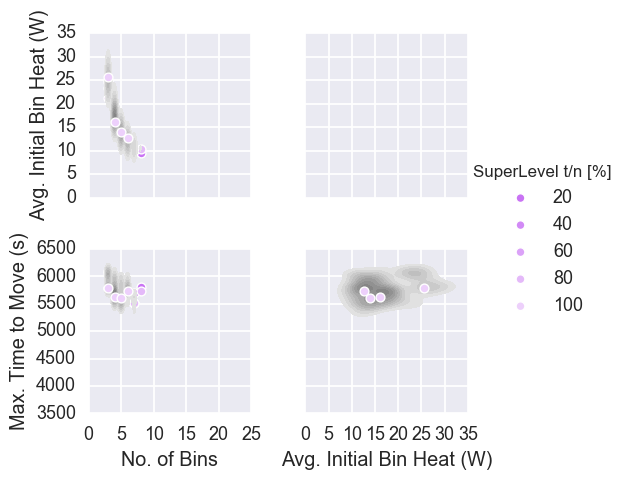

In [68]:
seaborn.set_context('talk')
plotname = kwargs['folder'] + '24eaf_' + kwargs['MethodName']
opcat = kwargs['opcat']
cmap = seaborn.light_palette('grey', as_cmap=True)

scat = PartialGrid(df_lsa, vars=opcat, hue='SuperLevel t/n [%]', palette=pal)
scat = scat.map_lower(pyplot.scatter, linewidths=1, edgecolor="w", s=40)
subplots =  [(0, 0), (1, 0), (1, 1)]
subplots_vars = [(0, 1), (0, 2), (1, 2)]
for pn in range(len(subplots)):
    i, j = subplots[pn]
    ax = scat.axes[i, j]
    x_var = opcat[subplots_vars[pn][0]]
    y_var = opcat[subplots_vars[pn][1]]
    
    ax.set_xlim(lim[subplots_vars[pn][0]])
    ax.set_ylim(lim[subplots_vars[pn][1]])
scat.add_legend()

In [18]:
class MixtureGrid(seaborn.axisgrid.Grid):
    
    def __init__(self, data, hue=None, hue_order=None, legend_out=True, dropna=True):
        # Next the private variables
        self._legend_data = {}
        self._legend_out = legend_out
        
        # Sort out the hue variable
        self._hue_var = hue
        if hue is None:
            self.hue_names = ["_nolegend_"]
            self.hue_vals = pd.Series(["_nolegend_"] * len(data),
                                      index=data.index)
        else:
            hue_names = utils.categorical_order(data[hue], hue_order)
            if dropna:
                # Filter NA from the list of unique hue names
                hue_names = list(filter(pd.notnull, hue_names))
            self.hue_names = hue_names
            self.hue_vals = data[hue]
        
    def get_legend_data(self):
        # This module returns labels and handle for adding a legend.
        label_order = np.sort(list(self._legend_data.keys()))
        blank_handle = patches.Patch(alpha=0, linewidth=0)
        handles = [self._legend_data.get(l, blank_handle) for l in label_order]
        return label_order, handles
    
    def set_figure(self, fig, axes):
        self.fig = fig
        self.axes = axes

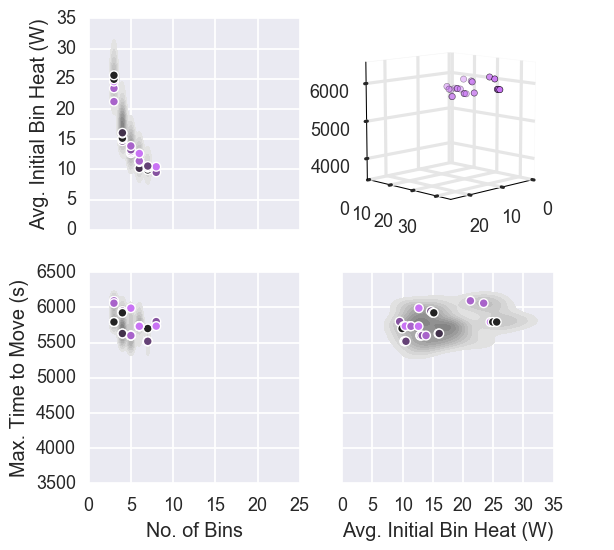

In [11]:
seaborn.set_context('talk')
plotname = kwargs['folder'] + '24eaf_' + kwargs['MethodName']
opcat = kwargs['opcat']
cmap = seaborn.light_palette('grey', as_cmap=True)

# Create the figure and the array of subplots
size=3 
aspect=1
figsize = 2 * size * aspect, 2 * size
# fig, axes = pyplot.subplots(2, 2, figsize=figsize, squeeze=False)
fig = pyplot.figure(figsize=figsize)
grid = MixtureGrid(df_lsa, hue='SuperLevel t/n [%]')

# Plot df_lsa and df_x in map_lower manually
subplots = [1, 3, 4]
subplots_vars = [(0, 1), (0, 2), (1, 2)]
subplots_labels = [(None, opcat[1]), (opcat[0], opcat[2]), (opcat[1], None)]
for pn in range(len(subplots)):
    seaborn.set_style('darkgrid')
    ax = fig.add_subplot(2, 2, subplots[pn])
    x_var = opcat[subplots_vars[pn][0]]
    y_var = opcat[subplots_vars[pn][1]]
    seaborn.kdeplot(df_x[x_var], df_x[y_var], shade=True, shade_lowest=False, ax=ax, cmap=cmap)
    grid._update_legend_data(ax)
    ax.scatter(df_lsa[x_var], df_lsa[y_var], c=pal, linewidths=1, edgecolor="w", s=40)
    if subplots_labels[pn][0]:
        ax.set_xlabel(subplots_labels[pn][0])
    else:
        ax.set_xlabel("")
        ax.get_xaxis().set_ticklabels([])
    if subplots_labels[pn][1]:
        ax.set_ylabel(subplots_labels[pn][1])
    else:
        ax.set_ylabel("")
        ax.get_yaxis().set_ticklabels([])
    ax.set_xlim(lim[subplots_vars[pn][0]])
    ax.set_ylim(lim[subplots_vars[pn][1]])
    
# Plot 3D version of df_x
seaborn.set_style('whitegrid')
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(df_lsa[opcat[0]], df_lsa[opcat[1]], df_lsa[opcat[2]], c=pal)
# Change tick spacing
[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('right') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
# Change tick placement
ax.set_xlim(lim[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylim(lim[1])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_zlim(lim[2])
ax.zaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.view_init(elev=10, azim=45)
# Change background color
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Add legend and save
# Find the data for the legend
label_order, handles = grid.get_legend_data()
fig.legend(handles, label_order, 'center right')
pyplot.savefig(plotname + '.eps', format='eps', dpi=4000)
pyplot.savefig(plotname + '.pdf', format='pdf', dpi=4000)

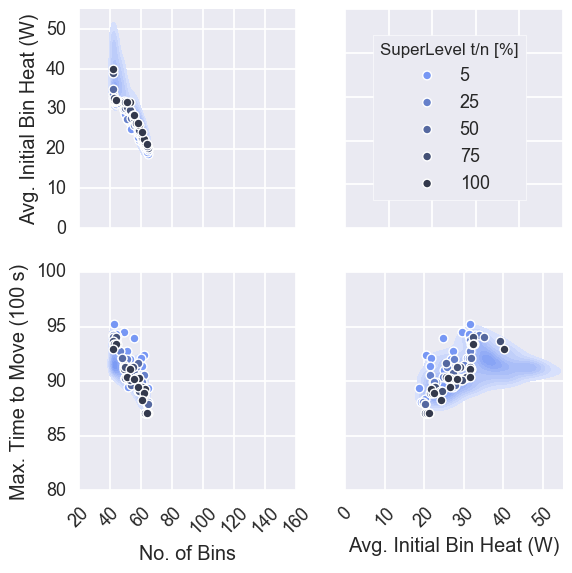

In [36]:
seaborn.set_context('talk')
plotname = kwargs['folder'] + '1000eaf_' + kwargs['MethodName']
opcat = kwargs['opcat']
# Set colors for lsa data and for x data
pal = seaborn.dark_palette(colors[kwargs['opal']], reverse=True)
pal_light = seaborn.light_palette(colors[kwargs['opal']], reverse=True)
cmap = seaborn.light_palette(colors[kwargs['opal']], as_cmap=True)

# Create the figure and the array of subplots
size=3 
aspect=1
figsize = 2 * size * aspect, 2 * size
fig = pyplot.figure(figsize=figsize)
grid = MixtureGrid(df_lsa, hue='SuperLevel t/n [%]', legend_out=False)

# Plot df_lsa and df_x in map_lower manually
subplots = [1, 3, 4]
subplots_vars = [(0, 1), (0, 2), (1, 2)]
subplots_labels = [(None, opcat[1]), (opcat[0], opcat[2]), (opcat[1], None)]
scale_y2 = 100
for pn in range(len(subplots)):
    seaborn.set_style('darkgrid')
    ax = fig.add_subplot(2, 2, subplots[pn])
    x_var = opcat[subplots_vars[pn][0]]
    y_var = opcat[subplots_vars[pn][1]]
    seaborn.kdeplot(df_x[x_var], df_x[y_var], shade=True, shade_lowest=False, ax=ax,cmap=cmap)
    # Add scatter plot by hues
    hue_grouped = df_lsa.groupby(grid.hue_vals)
    for k, label_k in enumerate(grid.hue_names):
        # Attempt to get data for this level, allowing for empty
        try:
            data_k = hue_grouped.get_group(label_k)
        except KeyError:
            data_k = pd.DataFrame(columns=self.data.columns, dtype=np.float)
        pyplot.sca(ax)
        color = pal[k] 
        pyplot.scatter(data_k[x_var], data_k[y_var], label=label_k, color=color, linewidths=1, edgecolor="w", s=40)
    grid._update_legend_data(ax)
    if subplots_labels[pn][0]:
        ax.set_xlabel(subplots_labels[pn][0])
        # Set the tick labels to be at a 45 degree angle for better fit
        ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda xax, p: format(int(xax))))
        pyplot.setp(ax.get_xticklabels(), rotation=45)
    else:
        ax.set_xlabel("")
        ax.get_xaxis().set_ticklabels([])
    if subplots_labels[pn][1]:
        label = subplots_labels[pn][1]
        if label == opcat[2]:
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y2))
            ax.yaxis.set_major_formatter(ticks_y)
            ax.set_ylabel('Max. Time to Move (100 s)')
        else:
            ax.set_ylabel(label)
    else:
        ax.set_ylabel("")
        ax.get_yaxis().set_ticklabels([])
    ax.set_xlim(lim[subplots_vars[pn][0]])
    ax.set_ylim(lim[subplots_vars[pn][1]])
ax = fig.add_subplot(2, 2, 2)
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])

# Add legend and save
axes = np.array(fig.get_axes())
grid.set_figure(fig, axes)
grid.axes[0].set_zorder(100)
grid.add_legend(bbox_to_anchor=(2.1, 0.925, 0, 0), frameon=True)
pyplot.tight_layout()
pyplot.savefig(plotname + '.eps', format='eps', dpi=4000)
pyplot.savefig(plotname + '.pdf', format='pdf', dpi=4000)